In [1]:
from spark import Spark
import tweet_volume as funcs
import matplotlib.pyplot as plt
from pyspark.sql import functions as fs
import os 
import pandas as pd
from plotting import double_plot
from settings import CRYPTO_DIR

In [2]:
spark = Spark('load', 'local')
sess = spark.session()

In [3]:
# Load main data frame (according to the provided schema). It will consist of all tweet data
main_df = funcs.load_dataframe(sess, funcs.default_loc, funcs.schema)

# Print first row (e.g. the first tweet in the df)
main_df.first()

AnalysisException: 'Path does not exist: file:/cs/unique/ls99-kf39-cs5052/data/tweets/*.json;'

In [4]:
# Parse the raw timestamp column of the main df into proper Timestamps
parsed_time_df = funcs.parse_timestamp(main_df)

In [8]:
# With Timestamps parsed, group all tweets together by the day in which they were posted
volume_df = parsed_time_df.withColumn("date", fs.date_format("timestamp", "yyyy-MM-dd")).groupBy("date").count() .toPandas()

# Eliminate rows with empty columns, and print out the remaining contents
volume_df.dropna()
volume_df

,date,count
0,2017-10-20,256370
1,2017-10-31,152224
2,2017-11-01,290947
3,2017-10-24,125656
4,2017-10-22,307229
5,None,2
6,2017-11-10,214538
7,2017-11-23,215200
8,2017-11-16,442745
9,2017-11-14,382167


In [24]:
# Load all crypto price data, and set the dataframe's index to be the datetimes
crix = funcs.load_crix()

# Print contents
crix

,price
date,
2017-10-10,12025.6771
2017-10-11,12130.8959
2017-10-12,12843.3856
2017-10-13,13656.6074
2017-10-14,13755.6341
2017-10-15,13778.8921
2017-10-16,13787.9659
2017-10-17,13508.3117
2017-10-18,13334.0485


In [20]:
# In-place override of volume_df's current index to be the date column.
# Ensure each entry in this column is parsed as well
volume_df.set_index('date', inplace=True)
volume_df.index = pd.to_datetime(volume_df.index)

# Combine the overall crypto price data and the volume_df, to prepare to draw a correlation
# between crypto-currency price and the amount of tweets for a given day
crix_and_vol = crix
crix_and_vol['volume'] = volume_df['count']
crix_and_vol = crix_and_vol.dropna()

KeyError: 'date'

In [29]:
# Find the correlation between price and volume
crix_and_vol.corr()

,price,volume
price,1.000000,0.660629
volume,0.660629,1.000000


In [30]:
# Graph the overall correlation with 3 axes: Price, Data, and Volume.
# This graph will show how the number of tweets on a given day correlates with the price 
scaled_price = crix_and_vol.price * (crix_and_vol.volume.iloc[0] / crix_and_vol.price.iloc[0])
double_plot([crix_and_vol.price, crix_and_vol.volume], ['Index Price', 'Tweets'], ['Date', 'Price', 'Volume'], "Price vs Tweet Volume", crix_and_vol.index.tolist())

In [5]:
# Filter out all tweets specifically about bitcoin
btc_df_vol = parsed_time_df.filter(fs.lower(main_df['text']).like("%bitcoin%") | fs.lower(main_df['text']).like("%btc%"))

# Create a 'date' column by parsing the raw timestamp column, and grouping together by day
btc_df_vol = btc_df_vol.withColumn("date", fs.date_format("timestamp", "yyyy-MM-dd")).groupBy("date").count().toPandas()

# Remove incomplete rows and update the index to be parsed timestamps
btc_df_vol.dropna()
btc_df_vol.set_index('date', inplace=True)
btc_df_vol.index = pd.to_datetime(btc_df_vol.index)

# Print bitcoin df
btc_df_vol

,count
date,
2017-10-20,129752
2017-10-31,75257
2017-11-01,147054
2017-10-24,63104
2017-10-22,130149
2017-11-10,98193
2017-11-23,81247
2017-11-16,182179
2017-11-14,163515


In [12]:
# Load in bitcoin-related crypto price data. Then, parse the index column as timestamps 
btc = pd.read_csv(os.path.join(CRYPTO_DIR, "KRAKEN_BTC_EUR.csv"), index_col=0)
btc.index = pd.to_datetime(btc.index)

# Combine the bitcoin price data with the dataframe representing 
# the volume of bitcoin tweets per day
btc_and_vol = btc
btc_and_vol['price'] = btc_and_vol.weightedAverage
btc_and_vol['volume'] = btc_df_vol['count']
btc_and_vol = btc_and_vol.dropna()
btc_and_vol


,close,high,low,open,since,volume,weightedAverage,price
date,,,,,,,,
2017-10-19,4719.9,4759.8,4696.0,4749.9,1508371200000000000,74350.0,4727.3354,4727.3354
2017-10-20,4816.1,4819.9,4802.5,4808.6,1508457600000000000,129752.0,4810.3926,4810.3926
2017-10-21,5047.5,5070.0,5040.0,5069.0,1508544000000000000,134881.0,5050.1973,5050.1973
2017-10-22,5113.7,5128.1,5100.1,5110.3,1508630400000000000,130149.0,5112.1416,5112.1416
2017-10-23,5061.9,5089.9,5049.9,5089.3,1508716800000000000,163773.0,5066.1970,5066.1970
2017-10-24,4940.9,5010.7,4917.6,5006.9,1508803200000000000,63104.0,4949.3550,4949.3550
2017-10-25,4722.8,4729.9,4671.5,4699.2,1508889600000000000,53184.0,4701.4316,4701.4316
2017-10-26,4863.5,4883.7,4860.1,4879.9,1508976000000000000,118087.0,4872.2173,4872.2173
2017-10-31,5262.0,5274.0,5244.2,5255.4,1509408000000000000,75257.0,5258.5103,5258.5103


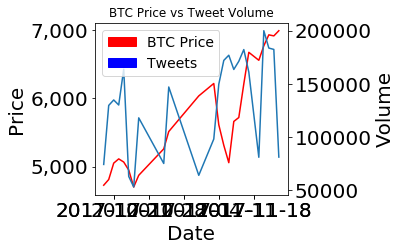

0.30750634486637513

In [13]:

double_plot([btc_and_vol.price, btc_and_vol.volume], ['BTC Price', 'Tweets'], ['Date', 'Price', 'Volume'], "BTC Price vs Tweet Volume", btc_and_vol.index.tolist())
btc_and_vol.corr().price.volume


Market correlation to tweet volume: 0.3781


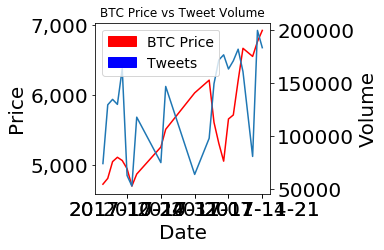

In [8]:
funcs.find_currency_correlation(parsed_time_df, "BTC")


In [8]:
# Filter out all tweets specifically about ethereum
eth_df_vol = parsed_time_df.filter(fs.lower(main_df['text']).like("%ether%") | fs.lower(main_df['text']).like("%eth%") | fs.lower(main_df['text']).like("%ethereum%"))

# Create a 'date' column by parsing the raw timestamp column, and grouping together by day
eth_df_vol = eth_df_vol.withColumn("date", fs.date_format("timestamp", "yyyy-MM-dd")).groupBy("date").count().toPandas()

# Remove incomplete rows and update the index to be parsed timestamps
eth_df_vol = eth_df_vol.dropna()
eth_df_vol.set_index('date', inplace=True)
eth_df_vol.index = pd.to_datetime(eth_df_vol.index)

# Print ethereum df
eth_df_vol

,count
date,
2017-10-20,33089
2017-10-31,17956
2017-11-01,37185
2017-10-24,17504
2017-10-22,38421
2017-11-10,24914
2017-11-23,27057
2017-11-16,49582
2017-11-14,45862


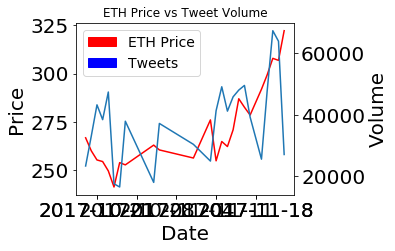

0.39946022045860696

In [9]:
# Load in ethereum-related crypto price data. Then, parse the index column as timestamps 
eth = pd.read_csv(os.path.join(CRYPTO_DIR, "KRAKEN_ETH_EUR.csv"), index_col=0)
eth.index = pd.to_datetime(eth.index)

# Combine the ethereum price data with the dataframe representing 
# the volume of ethereum tweets per day
eth_and_vol = eth
eth_and_vol['price'] = eth_and_vol.weightedAverage
eth_and_vol['volume'] = eth_df_vol['count']
eth_and_vol = eth_and_vol.dropna()

# Graph the data
double_plot([eth_and_vol.price, eth_and_vol.volume], ['ETH Price', 'Tweets'], ['Date', 'Price', 'Volume'], "ETH Price vs Tweet Volume", eth_and_vol.index.tolist())
eth_and_vol.corr().price.volume


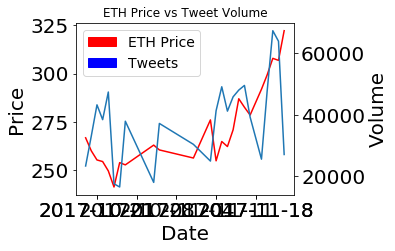

0.39946022045860696

In [ ]:
funcs.find_currency_correlation(parsed_time_df, "ETH")


Market correlation to tweet volume: 0.5386


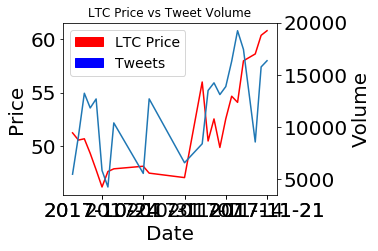

In [12]:
funcs.find_currency_correlation(parsed_time_df, "LTC")

Market correlation to tweet volume: 0.2697


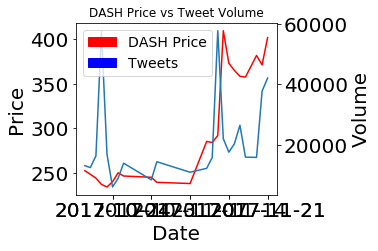

In [5]:
funcs.find_currency_correlation(parsed_time_df, "BCH")


Market correlation to tweet volume: 0.2697


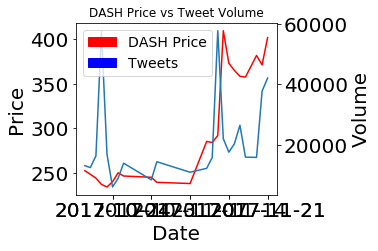

In [6]:
funcs.find_currency_correlation(parsed_time_df, "DASH")


Market correlation to tweet volume: 0.2697


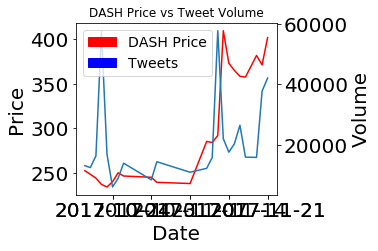

In [7]:
funcs.find_currency_correlation(parsed_time_df, "ETC")


Market correlation to tweet volume: 0.2697


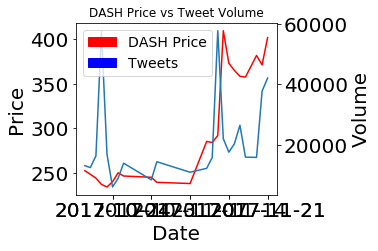

In [5]:
funcs.find_currency_correlation(parsed_time_df, "XMR")
